# Series Temporales - Time Series

Trabajo utilizado en la diplomatura en Data Science con R y Python dictado por la docente: Virginia Forcone, el cual fue realizado a partir de un dataset de Kaggle. El proyecto consiste en realizar un análisis de series temporales en Python. Se analizará la serie temporal que registra el consumo de energía eléctrica de la ciudad de Tetouan, Marruecos, medido durante el año 2017 en intervalos de 10 min. Se realizará el análisis exploratorio del set de datos, de la serie temporal en sí misma y se aplicarán dos modelos para analizar y predecir los valores de la serie temporal: SARIMA y TBATS. Luego se intentara extender el conocimiento hacia los demas features presentes en el dataset.

https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption?datasetId=2380926&sortBy=dateRun&tab=bookmarked&sort=published

**The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by 9 feature columns.**

- Date Time: Time window of ten minutes.
- Temperature: Weather Temperature.
- Humidity: Weather Humidity.
- Wind Speed: Wind Speed.
- General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
- Diffuse Flows
- Zone 1 Power Consumption
- Zone 2 Power Consumption
- Zone 3 Power Consumption

# Librerías a utilizar

- Ingesta y tratamiento de datos: pandas
- Gráficos: matplotlib y seaborn
- Análisis de la serie temporal: statsmodels, pmdarima y TBATS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tbats import TBATS

# Carga de datos 

In [3]:
data = pd.read_csv('powerconsumption.csv', sep=',', parse_dates=[0])

data

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


# Análisis Exploratorio 

In [4]:
print('\nTipos de datos:\n', data.dtypes)


Tipos de datos:
 Datetime                  datetime64[ns]
Temperature                      float64
Humidity                         float64
WindSpeed                        float64
GeneralDiffuseFlows              float64
DiffuseFlows                     float64
PowerConsumption_Zone1           float64
PowerConsumption_Zone2           float64
PowerConsumption_Zone3           float64
dtype: object


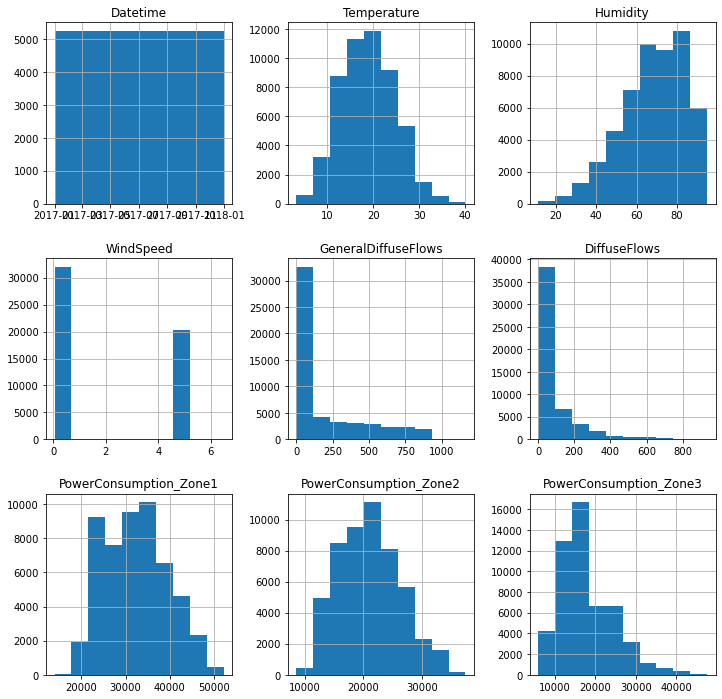

In [5]:
data.hist(figsize=(12,12))
plt.show()

In [6]:
data.columns

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object')

# Construcción de las series temporales 

Se trabajará en un principio con el consumo energetico de la zona 1 pero igualmente se construye una serie temporal para cada columna, utilizando la variable "Datetime" como índice y las demas columnas como valores.

In [7]:
powerZ1 = pd.Series(data=data['PowerConsumption_Zone1'].values, index=pd.to_datetime(data['Datetime'].values))
powerZ2 = pd.Series(data=data['PowerConsumption_Zone2'].values, index=pd.to_datetime(data['Datetime'].values))
powerZ3 = pd.Series(data=data['PowerConsumption_Zone3'].values, index=pd.to_datetime(data['Datetime'].values))
df = pd.Series(data=data['DiffuseFlows'].values, index=pd.to_datetime(data['Datetime'].values))
gdf = pd.Series(data=data['GeneralDiffuseFlows'].values, index=pd.to_datetime(data['Datetime'].values))
ws = pd.Series(data=data['WindSpeed'].values, index=pd.to_datetime(data['Datetime'].values))
hum = pd.Series(data=data['Humidity'].values, index=pd.to_datetime(data['Datetime'].values))
temp = pd.Series(data=data['Temperature'].values, index=pd.to_datetime(data['Datetime'].values))

powerZ1

2017-01-01 00:00:00    34055.69620
2017-01-01 00:10:00    29814.68354
2017-01-01 00:20:00    29128.10127
2017-01-01 00:30:00    28228.86076
2017-01-01 00:40:00    27335.69620
                          ...     
2017-12-30 23:10:00    31160.45627
2017-12-30 23:20:00    30430.41825
2017-12-30 23:30:00    29590.87452
2017-12-30 23:40:00    28958.17490
2017-12-30 23:50:00    28349.80989
Length: 52416, dtype: float64

# Analisis Exploratorio de la Serie Temporal

- Datos faltantes
- Visualización 
- Funciones de correlación
- Analisis de estacionariedad
- Descomposición

**Datos faltantes:** 

In [8]:
print('\nFrecuencia de registros:', pd.infer_freq(powerZ1.index)) #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print('\nCantidad de datos faltantes:', powerZ1.isnull().sum())


Frecuencia de registros: 10T

Cantidad de datos faltantes: 0


In [9]:
#Si existen huecos en el índice completar mediante
#             powerZ1 = powerZ1.resample('10T').asfreq()

#Si existen datos faltantes:
#En los extremos de la serie -> rellenar con el primer o último dato no nulo mediante
#             powerZ1 = powerZ1.bfill()
#             powerZ1 = powerZ1.ffill()
#En el cuerpo de la serie -> rellenar mediante interpolación
#             powerZ1 = powerZ1.interpolate(method='linear')

**Visualización:**

El primer gráfico corresponde a todos los valores de la serie temporal lo que equivale a 1 año de datos, y luego el segundo grafico corresponde a una porción filtrada equivalente al ultimo mes, esto se realiza con el fin de observar posibles variaciones estacionales o ciclicas.

Lo que podemos observar es una variación diaria (Periodo 144: 10' x 6 x 24), más una variación semanal.

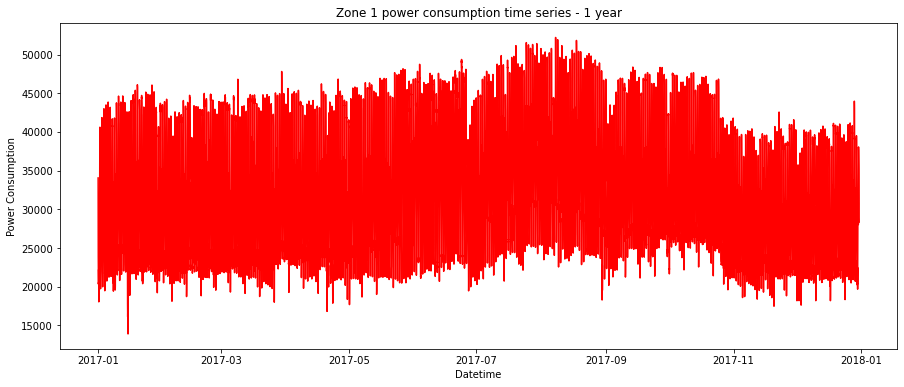

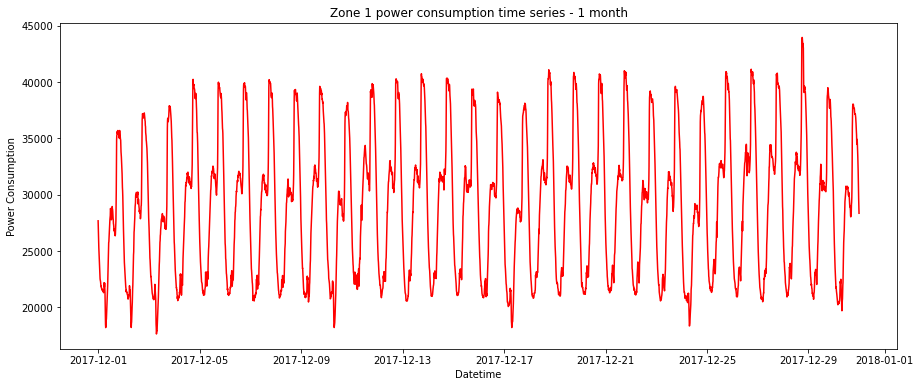

In [10]:
plt.figure(figsize=(15,6))
plt.plot(powerZ1, linestyle='-', color='red')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Zone 1 power consumption time series - 1 year')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(powerZ1['2017-12-01 00:00:00':], linestyle='-', color='red')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Zone 1 power consumption time series - 1 month')
plt.show()

**NOTA:** Computacionalmente es muy costoso modelar la serie temporal completa con un modelo SARIMA, además de que el modelo no soporta múltiples periodos estacionales, por lo que se modelará sólo el periodo correspondiente a la última semana.

In [11]:
powerZ1_dec = powerZ1['2017-12-24 00:00:00':]
powerZ1_dec

2017-12-24 00:00:00    28112.54753
2017-12-24 00:10:00    27528.51711
2017-12-24 00:20:00    26743.72624
2017-12-24 00:30:00    26104.94297
2017-12-24 00:40:00    25484.41065
                          ...     
2017-12-30 23:10:00    31160.45627
2017-12-30 23:20:00    30430.41825
2017-12-30 23:30:00    29590.87452
2017-12-30 23:40:00    28958.17490
2017-12-30 23:50:00    28349.80989
Length: 1008, dtype: float64

**Funciones de correlación:** 

A continuacion se muestran los gráficos de las funciones de autocorrelación simple y parcial con el fin de observar la estacionalidad de esta nueva serie, analizar si la serie es estacionaria o no (ya sabemos de que no, pues contiene periodos estacionales) y para luego construir el modelo SARIMA.

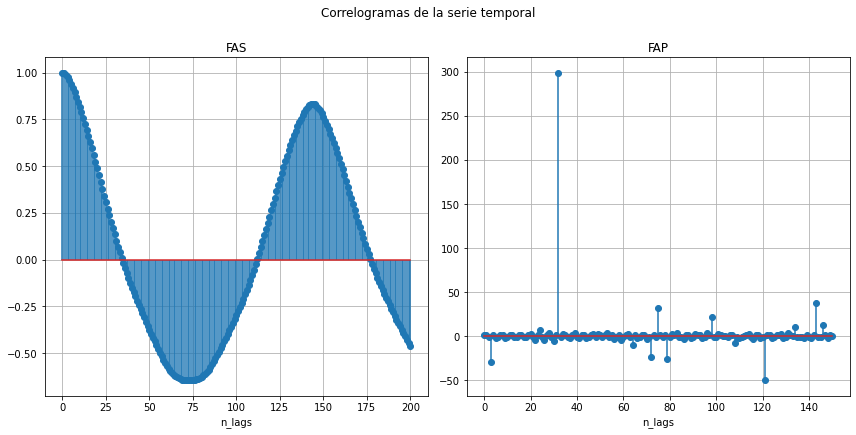

In [11]:
fas = sm.tsa.acf(powerZ1_dec, nlags=200)
fap = sm.tsa.pacf(powerZ1_dec, nlags=150) #Puede dar valores >1 cuando la serie no es estacionaria

fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Correlogramas de la serie temporal', y=1)
axs[0].stem(fas)
axs[0].set_title('FAS')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap)
axs[1].set_title('FAP')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()

**NOTA:**

- Se observan valores mayores a 1 en la FAP, lo cual es un indicador de no estacionariedad de la serie temporal.
- Se observa que la FAS no decae abruptamente a cero para k>0
- Se observa el periodo diario de la serie, correspondiente a 144 retrasos (muestras cada 10 min equivalen a 6 muestras por hora, con lo cual, 6x24=144).

**Medias móviles y desviación estándar**

Otra herramienta a la hora de determinar la estacionariedad de la serie temporal es el gráfico de medias móviles y su correspondientes desviaciones estándar, las cuales, si la serie es estacionaria, son constantes. Es conveniente utilizar el periodo de estacionalidad de la serie a la hora de calcular las medias móviles.

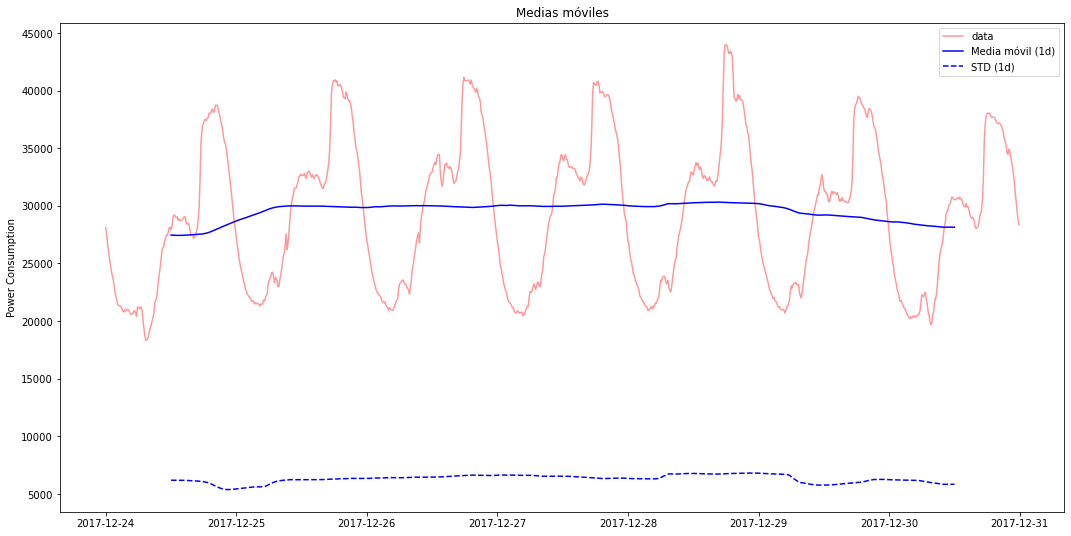

In [12]:
MMd = powerZ1_dec.rolling(144, center=True).mean()
STDd = powerZ1_dec.rolling(144, center=True).std()

plt.figure(figsize=(18,9))
plt.plot(powerZ1_dec, linestyle='-', color='red', alpha=0.4, label='data')
plt.plot(MMd, linestyle='-', color='b', label='Media móvil (1d)')
plt.plot(STDd, linestyle='--', color='b', label='STD (1d)')
plt.ylabel('Power Consumption')
plt.title('Medias móviles', y=1)
plt.legend()
plt.show()

**NOTA:** Se observa que, en este trozo de 1 semana de la serie temporal original, la media móvil es cuasi-constante. Si bien sabemos que nuestra serie no es estacionaria pues contiene un periodo estacional, este hecho nos demuestra de que la estacionalidad de la serie tiene periodo fijo (no es una ciclicidad) y magnitud que no varía significativamente con el tiempo.

**Tests de estacionariedad:** 

Una manera de asegurar esto es mediante los tests de ADF y KPSS, los cuales también sugieren la cantidad de diferenciaciones necesarias para hacer la serie temporal estacionaria. A continuación definimos las dos funciones para poder realizar los test de estacionariedad.

In [13]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value",
                                             "Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [14]:
adf_test(powerZ1_dec)
print('\nDiferenciaciones necesarias según ADF:', pm.arima.utils.ndiffs(powerZ1_dec, test='adf'))
print('\n')
kpss_test(powerZ1_dec)
print('\nDiferenciaciones necesarias según KPSS:', pm.arima.utils.ndiffs(powerZ1_dec, test='kpss'))

Results of Dickey-Fuller Test:
Test Statistic                   -4.508960
p-value                           0.000189
Lags Used                         5.000000
Number of Observations Used    1002.000000
Critical Value (1%)              -3.436893
Critical Value (5%)              -2.864429
Critical Value (10%)             -2.568308
dtype: float64

Diferenciaciones necesarias según ADF: 0


Results of KPSS Test:
Test Statistic            0.128273
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Diferenciaciones necesarias según KPSS: 0


C:\Users\Facu\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**NOTA:** Se observa que los tests concluyen en que la serie es estacionaria, aunque tenemos evidencia de que no lo es. Esta es una buena oportunidad para remarcar que todas estas estrategias de análisis exploratorio de la serie son importantes, al igual que nuestra capacidad de análisis de los resultados, para luego sacar nuestras propias conlusiones. Si confiásemos al 100% en una única herramienta, podríamos arribar a resultados no convincentes.

**Descomposición:**

Se puede realizar una descomposición de la serie, la cual sugiere las componentes de la misma y posibles estacionalidades.

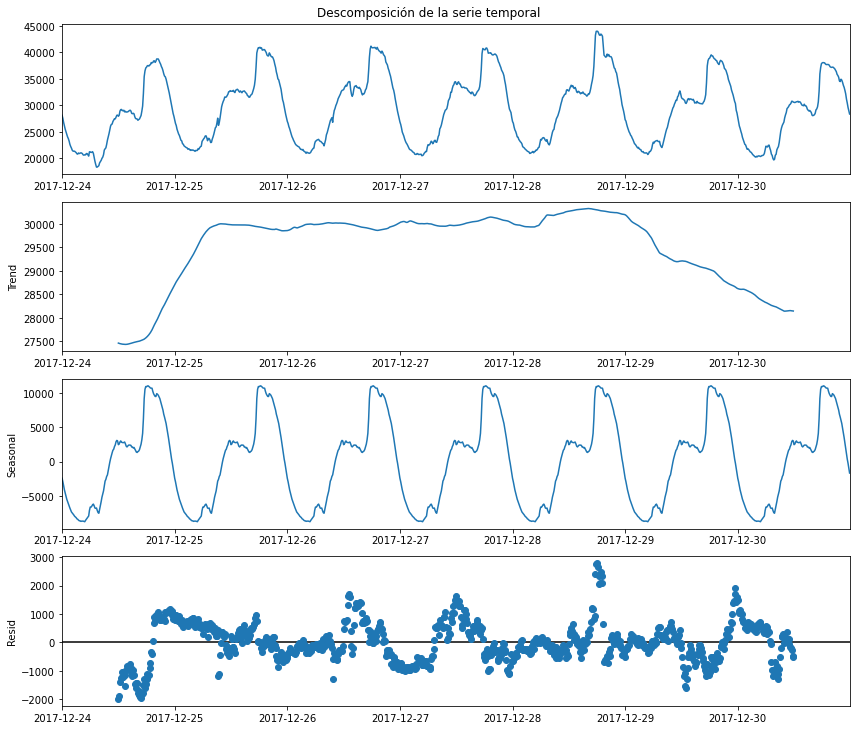

In [15]:
descomposicion_d = seasonal_decompose(powerZ1_dec, model='aditive', period=144) 
#normalmente no se indica el periodo a priori, pero en este caso evita un error.

plt.rcParams.update({'figure.figsize': (12,10)})
descomposicion_d.plot().suptitle('Descomposición de la serie temporal', y=1.01)
plt.show()

#La extracción de los componentes de la descomposición se realiza así:
#T = descomposicion_y.trend
#S = descomposicion_y.seasonal
#R = descomposicion_y.resid

**NOTA:** Todas las anteriores herramientas no son definitorias, sino que son guías para ayudar a comprender la naturaleza de los datos y a construir el modelo SARIMA que modelen dichos datos.

# Análisis SARIMA

## Determinación de los órdenes SARIMA

Existen dos maneras de determinar los órdenes SARIMA. Una de ellas es que sea inferido computacionalmente por medio de lo que se denomina un “auto-ARIMA” (computacionalmente costoso).

In [ ]:
search_model = pm.arima.auto_arima(powerZ1_dec, 
                                    start_p=1, start_q=1, d=0,
                                    max_p=7, max_q=7, max_d=5,
                                    max_order=None,
                                    m=144,
                                    seasonal=True,
                                    test='kpss',
                                    n_jobs=-1,
                                    trace=True,
                                    error_action='ignore')

Otra manera es tomar lo anterior como sugerencia y utilizar todo el análisis exploratorio realizado para elegir los órdenes. Para ello, se deben tener en cuenta las siguientes consideraciones:

- s: La estacionalidad la determina el periodo de ciclicidad de la FAS.
- d y D: Se debe bucar diferenciar la serie temporal hasta que la misma se parezca lo más posible a una serie estacionaria.
- p: El primer retraso con valor de FAP casi nulo.
- q: El primer retraso con valor de FAS casi nulo.
- P: Si la FAS es positiva en el retraso s, entonces P>0, caso contrario P=0.
- Q: Si la FAS es negativa en el retraso s, entonces Q>0, caso contrario Q=0.

Estas reglas no son determinantes y se pueden probar varios modelos buscando minimizar un criterio estadístico (AIC, BIC o HQIC). Más aún se puede jugar con valores diferentes de P y Q, aunque se recomienda que P+Q<3.

Ya sabemos el periodo estacional de la serie temporal, por lo tanto veamos las diferenciaciones necesarias para lograr una serie estacionaria (o lo más parecido posible), lo cual se corrobora por medio de los correlogramas.

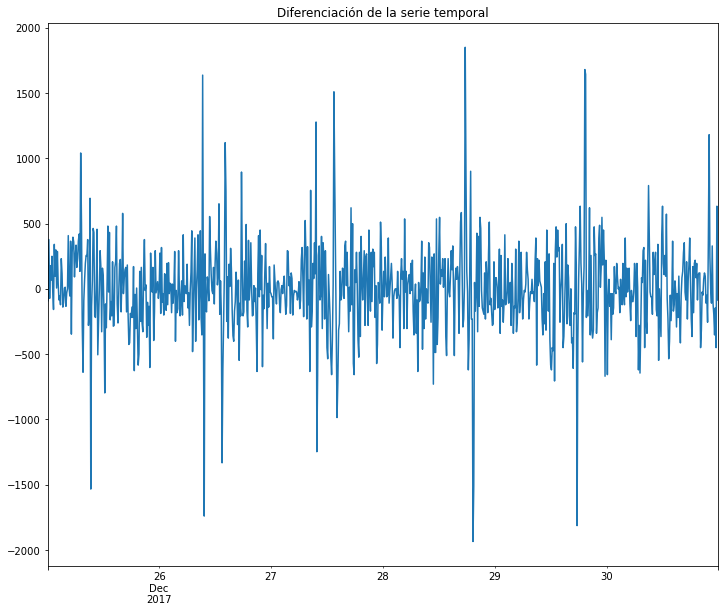

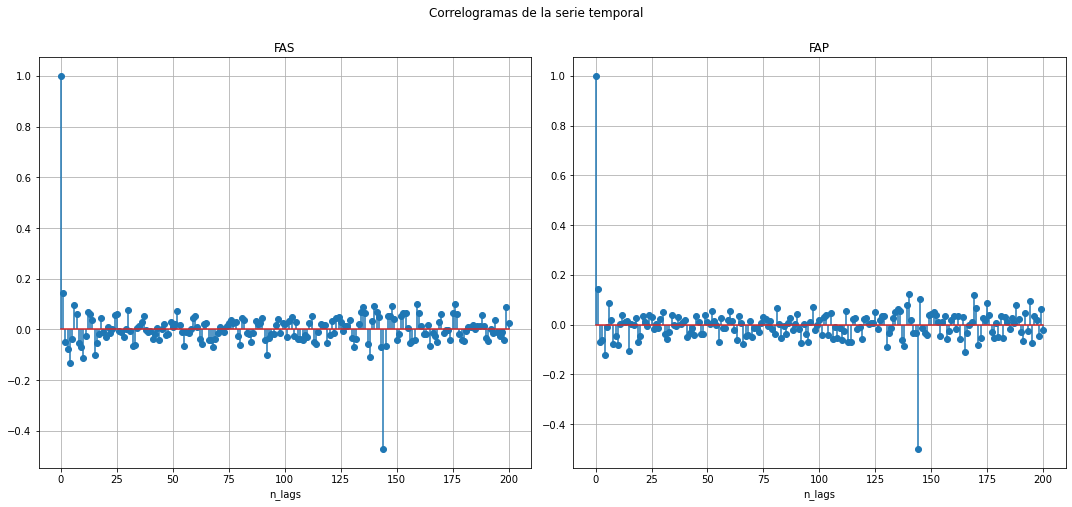

In [16]:
dif = sm.tsa.statespace.tools.diff(powerZ1_dec, k_diff=1, k_seasonal_diff=1,seasonal_periods=144)
dif.plot()
plt.title('Diferenciación de la serie temporal')
plt.show()
#El correlograma de dif se debe parecer al de ruido blanco.
fas_dif = sm.tsa.acf(dif, nlags=200)
fap_dif = sm.tsa.pacf(dif, nlags=200)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Correlogramas de la serie temporal', y=1)
axs[0].stem(fas_dif)
axs[0].set_title('FAS')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fap_dif)
axs[1].set_title('FAP')
axs[1].set_xlabel('n_lags')
axs[1].grid(True)
plt.tight_layout()
plt.show()

**NOTA:** Debido a esto y a todo el análisis exploratorio de la serie temporal, se proponen los siguientes órdenes SARIMA (los cuales pueden ajustarse hasta lograr buenos resultados).

In [17]:
s = 144
p = 2
q = 2
d = 1
P = 0
Q = 1
D = 1

## Separación de datos para entrenamiento y prueba

In [18]:
train = powerZ1_dec[:'2017-12-28 23:50:00']
test = powerZ1_dec['2017-12-29 00:00:00':]

## Entrenamiento del modelo

In [ ]:
model = ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
model = model.fit(low_memory=True)
print('Resumen modelo SARIMA\n', model.summary())

C:\Users\Facu\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\Facu\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\Facu\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\Facu\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


## Predicción y Evaluación del modelo

In [ ]:
pred = model.get_prediction(end=len(powerZ1_dec)-1)
pred_train = pred.predicted_mean[:'2017-12-28 23:50:00']
pred_test = pred.predicted_mean['2017-12-29 00:00:00':]
pred_conf_int = pred.conf_int()

err = powerZ1_dec - pred.predicted_mean

plt.figure(figsize=(18,9))
plt.plot(train, color='red', linestyle='-', label='Train')
plt.plot(test, color='indianred', linestyle='-', label='Test')
plt.plot(pred_train, color='teal', linestyle='-', label='Train pred')
plt.plot(pred_test, color='turquoise', linestyle='-', label='Test pred')
plt.fill_between(pred_conf_int.index, pred_conf_int['lower y'], pred_conf_int['upper y'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Predicción modelo SARIMA statsmodels (diciembre)')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Errores en el ajuste con statsmodels (diciembre)')
err1.plot(err, 'bo')
err1.set_ylim([-7000,7000])
err1.set_xlabel('Date')
err1.set_ylabel('Power Consumption')
sb.histplot(err, bins=13, kde=True, ax=err2, binrange=(-5000,5000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()

#Se puede utilizar de manera análoga la librería pmdarima para modelar la serie temporal

**NOTA:** Se puede observar que el modelo construido logra una predicción decente de los datos de prueba, logrando una distribución cuasi normal de los errores en la predicción, salvo en el conjunto de prueba donde la predicción tiene un sesgo positivo

## Predicción a futuro

Una vez que se está conforme con el modelo logrado, se puede utilizar éste para predecir valores futuros, es decir, de los que no se cuenta con datos para validar la calidad de la predicción. Para ello, es conveniente utilizar todos los datos disponibles para entrenar el modelo.

In [ ]:
futuro = pd.date_range('2017-12-31 00:00:00', periods=288, freq='10T')

model = ARIMA(powerZ1_dec, order=(p,d,q), seasonal_order=(P,D,Q,s))
model = model.fit(low_memory=True)
print('Resumen modelo SARIMA\n', model.summary())

In [ ]:
pred = model.get_prediction(end=len(powerZ1_dec)+len(futuro)-1)
pred_train = pred.predicted_mean[:'2017-12-30 23:50:00']
pred_futuro = pred.predicted_mean['2017-12-31 00:00:00':]
pred_conf_int = pred.conf_int()

plt.figure(figsize=(18,9))
plt.plot(powerZ1_dec, color='red', linestyle='-', label='Data')
plt.plot(pred_train, color='teal', linestyle='-', label='Current pred')
plt.plot(pred_futuro, color='b', linestyle='-', label='Future pred')
plt.fill_between(pred_conf_int.index, pred_conf_int['lower y'], pred_conf_int['upper y'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Predicción modelo SARIMA statsmodels (diciembre)')
plt.legend()
plt.show()

# Análisis TBATS

Este modelo tiene una implementación bastante simple ya que la búsqueda del mejor modelo lo hace computacionalmente por sí solo y tiene la ventaja extra de que permite modelar series temporales con múltiples periodos estacionales. Por estas razones los tiempos de ejecución pueden ser prolongados, dependiendo mucho de la cantidad de datos.

Aprovechando las ventajas de este modelo, utilizaremos la serie temporal original para entrenar y predecir valores. Antes de comenzar, repitamos los correlogramas para observar las múltiples estacionalidades de la serie temporal.

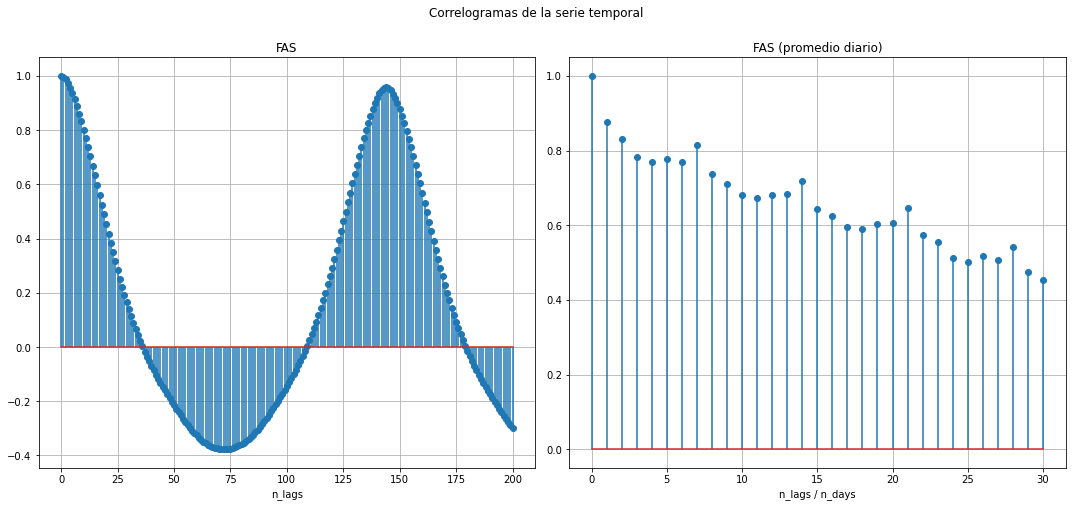

In [19]:
fas_d = sm.tsa.acf(powerZ1, nlags=200)
fas_s = sm.tsa.acf(powerZ1.resample('D').mean(), nlags=30)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
fig.suptitle('Correlogramas de la serie temporal', y=1)
axs[0].stem(fas_d)
axs[0].set_title('FAS')
axs[0].set_xlabel('n_lags')
axs[0].grid(True)
axs[1].stem(fas_s)
axs[1].set_title('FAS (promedio diario)')
axs[1].set_xlabel('n_lags / n_days')
axs[1].grid(True)
plt.tight_layout()
plt.show()

**NOTA:** Como habíamos notado al comienzo, hay una estacionalidad diaria y una semanal. Esto equivale a 144 y 1008 retrasos respectivamente. Ahora sí, construyamos el modelo. 

In [ ]:
# required on windows for multi-processing,
# see https://docs.python.org/2/library/multiprocessing.html#windows
if __name__ == '__main__':
    #DATA
    data = pd.read_csv('powerconsumption.csv', sep=',', parse_dates=True)

    #Armado de la serie temporal
    powerZ1 = pd.Series(data=data['PowerConsumption_Zone1'].values, index=pd.to_datetime(data['Datetime'].values))
    print('\nSERIE TEMPORAL:\n', powerZ1)

    #DIVISIÓN DE DATOS EN ENTRENAMIENTO Y TESTEO
    train = powerZ1[:'2017-09-30 23:50:00']
    test = powerZ1['2017-10-01 00:00:00':]    

    #MODELO
    estimator = TBATS(seasonal_periods=[144, 1008], n_jobs=3)
    fitted_model = estimator.fit(train)
    print('\nResumen del modelo:\n', fitted_model.summary())

    pred_train = pd.Series(data=fitted_model.y_hat, index=train.index)
    
    pred_test, conf_test = fitted_model.forecast(steps=len(test), confidence_level=0.95)
    pred_test = pd.Series(data=pred_test, index=test.index)
    conf_test = pd.DataFrame(data={'lower_bound':conf_test['lower_bound'], 'upper_bound':conf_test['upper_bound']}, index=test.index)
    
    err_train = pd.Series(data=fitted_model.resid, index=train.index)
    err_test = test - pred_test   
    err = pd.concat([err_train, err_test])


SERIE TEMPORAL:
 2017-01-01 00:00:00    34055.69620
2017-01-01 00:10:00    29814.68354
2017-01-01 00:20:00    29128.10127
2017-01-01 00:30:00    28228.86076
2017-01-01 00:40:00    27335.69620
                          ...     
2017-12-30 23:10:00    31160.45627
2017-12-30 23:20:00    30430.41825
2017-12-30 23:30:00    29590.87452
2017-12-30 23:40:00    28958.17490
2017-12-30 23:50:00    28349.80989
Length: 52416, dtype: float64


In [ ]:
#Visualización completa
plt.figure(figsize=(18,9))
plt.plot(train, color='red', linestyle='-', label='Train')
plt.plot(test, color='indianred', linestyle='-', label='Test')
plt.plot(pred_train, color='teal', linestyle='-', label='Train pred')
plt.plot(pred_test, color='turquoise', linestyle='-', label='Test pred')
plt.fill_between(conf_test.index, conf_test['lower_bound'], conf_test['upper_bound'], color='k', alpha=0.1, label='conf. int.', edgecolor=None)
plt.ylim(5000, 60000)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Predicción modelo TBATS')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Errores en el ajuste con TBATS')
err1.plot(err, 'bo')
#err1.set_ylim([-7000,7000])
err1.set_xlabel('Date')
err1.set_ylabel('Power Consumption')
sb.histplot(err, bins=13, kde=True, ax=err2, binrange=(-5000,5000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()

In [ ]:
#Visualización de 1 semana del conjunto train
plt.figure(figsize=(18,9))
plt.plot(train['2017-03-01 00:00:00':'2017-03-06 23:50:00'], color='red', linestyle='-', label='Train')
plt.plot(pred_train['2017-03-01 00:00:00':'2017-03-06 23:50:00'], color='teal', linestyle='-', label='Train pred')
#plt.ylim(-50, 350)
plt.xlabel('Datetime')
plt.ylabel('Power consumption')
plt.title('Predicción modelo TBATS')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Errores en el ajuste TBATS')
err1.plot(err['2017-03-01 00:00:00':'2017-03-06 23:50:00'], 'bo')
err1.set_xlabel('Datetime')
err1.set_ylabel('Power Consumption')
sb.histplot(err['2017-03-01 00:00:00':'2017-03-06 23:50:00'], bins=13, kde=True, ax=err2, binrange=(-2000,2000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()

In [ ]:
#Visualización de 15 días del conjunto test
plt.figure(figsize=(18,9))
plt.plot(test['2017-11-01 00:00:00':'2017-11-15 23:50:00'], color='indianred', linestyle='-', label='Test')
plt.plot(pred_test['2017-11-01 00:00:00':'2017-11-15 23:50:00'], color='turquoise', linestyle='-', label='Test pred')
#plt.ylim(-50, 250)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Predicción modelo TBATS')
plt.legend()
plt.show()

fig, (err1, err2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Errores en el ajuste TBATS')
err1.plot(err['2017-11-01 00:00:00':'2017-11-15 23:50:00'], 'bo')
err1.set_xlabel('Datetime')
err1.set_ylabel('Power Consumption')
sb.histplot(err['2017-11-01 00:00:00':'2017-11-15 23:50:00'], bins=13, kde=True, ax=err2, binrange=(-7000,7000))
err2.set_xlabel('Power Consumption')
plt.tight_layout()
plt.show()